The goal of this notebook is to train an ML linear regression model to predict covid case rates using a variety of features including covid data, demographic data, as well as the outcome of the 2020 presidential elections.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks
import keras_tuner as kt

pd.set_option("mode.chained_assignment", None)

Datasets:

covid_2022: https://data.cdc.gov/Public-Health-Surveillance/United-States-COVID-19-Community-Levels-by-County/3nnm-4jni

election: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ

vaccination: https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh

In [2]:
covid_2022 = pd.read_csv("covid_by_county.csv")
election = pd.read_csv("election_by_county.csv")
vaccination = pd.read_csv("vaccination_by_county.csv")

My first step was to perform a simple first sighting of the data.

In [3]:
print(covid_2022.info())
covid_2022

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35464 entries, 0 to 35463
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   county                              35464 non-null  object 
 1   county_fips                         35464 non-null  int64  
 2   state                               35464 non-null  object 
 3   county_population                   35460 non-null  float64
 4   health_service_area_number          35460 non-null  float64
 5   health_service_area                 35460 non-null  object 
 6   health_service_area_population      35460 non-null  float64
 7   covid_inpatient_bed_utilization     35397 non-null  float64
 8   covid_hospital_admissions_per_100k  35453 non-null  float64
 9   covid_cases_per_100k                35464 non-null  float64
 10  covid-19_community_level            35456 non-null  object 
 11  date_updated                        35464

,county,county_fips,state,county_population,health_service_area_number,health_service_area,health_service_area_population,covid_inpatient_bed_utilization,covid_hospital_admissions_per_100k,covid_cases_per_100k,covid-19_community_level,date_updated
0,American Samoa,60000,American Samoa,47392.0,901.0,American Samoa,47392.0,0.0,2.1,156.14,Low,2022-03-03
1,Guam,66000,Guam,168489.0,902.0,Guam,168489.0,15.2,38.6,833.88,High,2022-03-03
2,Commonwealth of the Northern Mariana Islands,69000,Commonwealth of the Northern Mariana Islands,51851.0,903.0,Commonwealth of the Northern Mariana Islands,51851.0,7.2,9.6,1267.09,Medium,2022-03-03
3,United States Virgin Islands,78000,United States Virgin Islands,106290.0,905.0,United States Virgin Islands,106290.0,2.4,0.9,78.09,Low,2022-03-03
4,American Samoa,60000,American Samoa,47392.0,901.0,American Samoa,47392.0,0.9,19.0,434.67,High,2022-03-10
...,...,...,...,...,...,...,...,...,...,...,...,...
35459,Wrangell Cty&Bor,2275,Alaska,2502.0,817.0,"Ketchikan Gateway Borough, AK - Wrangell-Peter...",25872.0,6.1,0.0,439.65,Medium,2022-05-05
35460,Commonwealth of the Northern Mariana Islands,69000,Commonwealth of the Northern Mariana Islands,51851.0,903.0,Commonwealth of the Northern Mariana Islands,51851.0,0.0,0.0,34.71,Low,2022-05-05
35461,United States Virgin Islands,78000,United States Virgin Islands,106290.0,905.0,United States Virgin Islands,106290.0,6.6,2.8,619.06,Medium,2022-05-05
35462,American Samoa,60000,American Samoa,47392.0,901.0,American Samoa,47392.0,2.1,2.1,118.16,Low,2022-05-05


In [4]:
print(election.info())
election

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72617 entries, 0 to 72616
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            72617 non-null  int64  
 1   state           72617 non-null  object 
 2   state_po        72617 non-null  object 
 3   county_name     72617 non-null  object 
 4   county_fips     72560 non-null  float64
 5   office          72617 non-null  object 
 6   candidate       72617 non-null  object 
 7   party           72617 non-null  object 
 8   candidatevotes  72617 non-null  int64  
 9   totalvotes      72617 non-null  int64  
 10  version         72617 non-null  int64  
 11  mode            72617 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 6.6+ MB
None


,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,AL GORE,DEMOCRAT,4942,17208,20220315,TOTAL
1,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,11993,17208,20220315,TOTAL
2,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,RALPH NADER,GREEN,160,17208,20220315,TOTAL
3,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,OTHER,OTHER,113,17208,20220315,TOTAL
4,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,AL GORE,DEMOCRAT,13997,56480,20220315,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...
72612,2020,WYOMING,WY,WASHAKIE,56043.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,3245,4032,20220315,TOTAL
72613,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,360,3560,20220315,TOTAL
72614,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JO JORGENSEN,LIBERTARIAN,46,3560,20220315,TOTAL
72615,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,OTHER,OTHER,47,3560,20220315,TOTAL


In [5]:
print(vaccination.info())
vaccination

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670545 entries, 0 to 1670544
Data columns (total 66 columns):
 #   Column                                   Non-Null Count    Dtype  
---  ------                                   --------------    -----  
 0   Date                                     1670545 non-null  object 
 1   FIPS                                     1670545 non-null  object 
 2   MMWR_week                                1670545 non-null  int64  
 3   Recip_County                             1670545 non-null  object 
 4   Recip_State                              1670513 non-null  object 
 5   Completeness_pct                         1669354 non-null  float64
 6   Administered_Dose1_Recip                 1619754 non-null  float64
 7   Administered_Dose1_Pop_Pct               1659345 non-null  float64
 8   Administered_Dose1_Recip_5Plus           467180 non-null   float64
 9   Administered_Dose1_Recip_5PlusPop_Pct    477260 non-null   float64
 10  Administered_Dose1

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Booster_Doses_Vax_Pct_UR_Equity,Booster_Doses_12PlusVax_Pct_UR_Equity,Booster_Doses_18PlusVax_Pct_UR_Equity,Booster_Doses_65PlusVax_Pct_UR_Equity,Census2019,Census2019_5PlusPop,Census2019_5to17Pop,Census2019_12PlusPop,Census2019_18PlusPop,Census2019_65PlusPop
0,05/05/2022,06005,18,Amador County,CA,97.6,27024.0,68.0,27016.0,70.8,...,7.0,7.0,7.0,6.0,39752.0,38140.0,4398.0,35819.0,33742.0,10945.0
1,05/05/2022,08023,18,Costilla County,CO,97.1,2439.0,62.7,NaN,NaN,...,8.0,8.0,8.0,7.0,3887.0,3699.0,553.0,3422.0,3146.0,1047.0
2,05/05/2022,12109,18,St. Johns County,FL,98.6,207815.0,78.5,207788.0,82.5,...,3.0,3.0,4.0,3.0,264672.0,251781.0,44300.0,228894.0,207481.0,54654.0
3,05/05/2022,13005,18,Bacon County,GA,89.4,3900.0,34.9,3900.0,37.5,...,6.0,6.0,6.0,5.0,11164.0,10398.0,2067.0,9309.0,8331.0,1878.0
4,05/05/2022,13031,18,Bulloch County,GA,89.4,31389.0,39.4,31387.0,41.8,...,6.0,6.0,7.0,6.0,79608.0,75062.0,11211.0,69037.0,63851.0,9268.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670540,12/13/2020,35041,51,Roosevelt County,NM,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,18500.0,NaN,NaN,15466.0,13995.0,NaN
1670541,12/13/2020,27047,51,Freeborn County,MN,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,30281.0,NaN,NaN,25977.0,23667.0,NaN
1670542,12/13/2020,49035,51,Salt Lake County,UT,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1160437.0,NaN,NaN,955797.0,851292.0,NaN
1670543,12/13/2020,17087,51,Johnson County,IL,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,12417.0,NaN,NaN,10948.0,10142.0,NaN


Next, I narrowed down my datasets and did some data wrangling to get the data ready for the ML model as well as to make it possible to merge the 3 datasets into one.

In [6]:
covid_select_2022 = covid_2022[["county",
                                "county_fips",
                                "state",
                                "covid_hospital_admissions_per_100k",
                                "covid_cases_per_100k",
                                "date_updated"]]

covid_select_2022["date_updated"] = covid_select_2022["date_updated"].astype("datetime64[ns]")

covid_select_2022["covid_cases_per_100k"] = (covid_select_2022["covid_cases_per_100k"]
    .astype(str)
    .str.replace(",", "")
    .astype(float))

covid_select_2022

,county,county_fips,state,covid_hospital_admissions_per_100k,covid_cases_per_100k,date_updated
0,American Samoa,60000,American Samoa,2.1,156.14,2022-03-03
1,Guam,66000,Guam,38.6,833.88,2022-03-03
2,Commonwealth of the Northern Mariana Islands,69000,Commonwealth of the Northern Mariana Islands,9.6,1267.09,2022-03-03
3,United States Virgin Islands,78000,United States Virgin Islands,0.9,78.09,2022-03-03
4,American Samoa,60000,American Samoa,19.0,434.67,2022-03-10
...,...,...,...,...,...,...
35459,Wrangell Cty&Bor,2275,Alaska,0.0,439.65,2022-05-05
35460,Commonwealth of the Northern Mariana Islands,69000,Commonwealth of the Northern Mariana Islands,0.0,34.71,2022-05-05
35461,United States Virgin Islands,78000,United States Virgin Islands,2.8,619.06,2022-05-05
35462,American Samoa,60000,American Samoa,2.1,118.16,2022-05-05


In [7]:
election_2020 = election[(election.year == 2020) &
                         (election.candidate == "JOSEPH R BIDEN JR") |
                         (election.candidate == "DONALD J TRUMP")].reset_index()

election_2020 = election_2020.assign(vote_pct = election_2020["candidatevotes"] / election_2020["totalvotes"])

election_2020_select = election_2020[["county_fips", "candidate", "vote_pct"]]

election_2020_select = (election_2020_select
                        .assign(key = (election_2020_select
                                       .groupby("candidate")
                                       .cumcount()))
                        .pivot(index = "key", columns = "candidate", values = ["county_fips", "vote_pct"]))

election_2020_select_1 = election_2020_select.iloc[:,:2]
election_2020_select_2 = election_2020_select.iloc[:,2:]

election_2020_select_1.columns.set_levels(["a", "b"], level = 1, inplace = True)

e_1 = election_2020_select_1.droplevel(level = 0, axis = 1)
e_2 = election_2020_select_2.droplevel(level = 0, axis = 1)

election_2020_select = pd.concat([e_1, e_2], axis = 1)
election_2020_select = election_2020_select.drop("a", axis = 1)
election_2020_select = election_2020_select.rename(columns = {"b": "county_fips",
                                                              "DONALD J TRUMP": "Trump",
                                                              "JOSEPH R BIDEN JR": "Biden"})

election_2020_select

<ipython-input-7-089ad611adb6>:18: FutureWarning: inplace is deprecated and will be removed in a future version.
  election_2020_select_1.columns.set_levels(["a", "b"], level = 1, inplace = True)


candidate,county_fips,Trump,Biden
key,,,
0,1001.0,0.714368,0.270184
1,1003.0,0.761714,0.224090
2,1005.0,0.534512,0.457882
3,1007.0,0.784263,0.206983
4,1009.0,0.895716,0.095694
...,...,...,...
5112,56037.0,0.732363,0.228950
5113,56039.0,0.293569,0.665990
5114,56041.0,0.792473,0.168200


Since I was planning to merge the datasets using the county fips codes, I needed to drop vaccination data that did not include a fips code.

In [8]:
vaccination_select = vaccination[["Date",
                                  "FIPS",
                                  "Recip_State",
                                  "Series_Complete_Pop_Pct",
                                  "Booster_Doses_Vax_Pct",
                                  "Census2019"]]

vaccination_select = vaccination_select.rename(columns = {"FIPS": "county_fips",
                                                          "Date": "date_updated",
                                                          "Census2019": "county_population"})

vaccination_select["county_fips"] = vaccination_select["county_fips"].replace(["UNK"], np.nan)
vaccination_select["county_fips"] = (vaccination_select["county_fips"]
                                     .astype(str)
                                     .astype(float))

vaccination_select["date_updated"] = pd.to_datetime(vaccination_select["date_updated"])

vaccination_select = vaccination_select[vaccination_select["county_fips"].notna()]

vaccination_select

,date_updated,county_fips,Recip_State,Series_Complete_Pop_Pct,Booster_Doses_Vax_Pct,county_population
0,2022-05-05,6005.0,CA,53.4,46.3,39752.0
1,2022-05-05,8023.0,CO,60.4,57.7,3887.0
2,2022-05-05,12109.0,FL,70.4,46.7,264672.0
3,2022-05-05,13005.0,GA,30.6,30.5,11164.0
4,2022-05-05,13031.0,GA,34.4,38.8,79608.0
...,...,...,...,...,...,...
1670540,2020-12-13,35041.0,NM,0.0,NaN,18500.0
1670541,2020-12-13,27047.0,MN,0.0,NaN,30281.0
1670542,2020-12-13,49035.0,UT,0.0,NaN,1160437.0
1670543,2020-12-13,17087.0,IL,0.0,NaN,12417.0


In [9]:
temp_2022 = pd.merge(covid_select_2022, election_2020_select, how = "inner", on = "county_fips")
temp_2022

,county,county_fips,state,covid_hospital_admissions_per_100k,covid_cases_per_100k,date_updated,Trump,Biden
0,Geneva County,1061,Alabama,20.9,140.84,2022-02-24,0.864727,0.127142
1,Geneva County,1061,Alabama,15.1,114.19,2022-03-03,0.864727,0.127142
2,Geneva County,1061,Alabama,7.6,60.90,2022-03-10,0.864727,0.127142
3,Geneva County,1061,Alabama,2.9,38.06,2022-03-24,0.864727,0.127142
4,Geneva County,1061,Alabama,3.6,15.23,2022-03-17,0.864727,0.127142
...,...,...,...,...,...,...,...,...
55820,Weston County,56045,Wyoming,0.0,14.44,2022-04-07,0.872753,0.101124
55821,Weston County,56045,Wyoming,0.0,0.00,2022-04-14,0.872753,0.101124
55822,Weston County,56045,Wyoming,0.0,0.00,2022-04-21,0.872753,0.101124
55823,Weston County,56045,Wyoming,0.0,14.44,2022-04-28,0.872753,0.101124


After merging the datasets, I searched for NA values in my features and filled in the missing values using linear interpolation. Unfortunately, some of the counties did not have any data on vaccination and booster rates. With no data to build on, I repalced the NAs in those counties by the national average in order to prevent skewing the data.

In [10]:
df_2022 = pd.merge(temp_2022, vaccination_select, how = "inner", on = ["date_updated", "county_fips"])
print(df_2022.info())
print(df_2022.isnull().sum())
df_2022 = df_2022.sort_values("date_updated").groupby("county_fips").apply(lambda group: group.interpolate(method = "linear", limit = 100, limit_direction = "both"))
print(df_2022.isnull().sum())

df_2022

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55825 entries, 0 to 55824
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   county                              55825 non-null  object        
 1   county_fips                         55825 non-null  int64         
 2   state                               55825 non-null  object        
 3   covid_hospital_admissions_per_100k  55809 non-null  float64       
 4   covid_cases_per_100k                55825 non-null  float64       
 5   date_updated                        55825 non-null  datetime64[ns]
 6   Trump                               55825 non-null  float64       
 7   Biden                               55825 non-null  float64       
 8   Recip_State                         55825 non-null  object        
 9   Series_Complete_Pop_Pct             55656 non-null  float64       
 10  Booster_Doses_Vax_Pct 

,county,county_fips,state,covid_hospital_admissions_per_100k,covid_cases_per_100k,date_updated,Trump,Biden,Recip_State,Series_Complete_Pop_Pct,Booster_Doses_Vax_Pct,county_population
0,Geneva County,1061,Alabama,20.9,140.84,2022-02-24,0.864727,0.127142,AL,39.9,31.7,26271.0
47465,Sherman County,48421,Texas,10.3,132.36,2022-02-24,0.893145,0.091734,TX,34.0,20.2,3022.0
8352,Cook County,13075,Georgia,27.7,57.90,2022-02-24,0.000000,0.000142,GA,40.4,29.6,17270.0
8351,Cook County,13075,Georgia,27.7,57.90,2022-02-24,0.158209,0.076475,GA,40.4,29.6,17270.0
8350,Cook County,13075,Georgia,27.7,57.90,2022-02-24,0.469225,0.143284,GA,40.4,29.6,17270.0
...,...,...,...,...,...,...,...,...,...,...,...,...
51939,Rockbridge County,51163,Virginia,1.9,44.30,2022-05-05,0.176699,0.229135,VA,46.1,20.5,22573.0
12173,Schley County,13249,Georgia,2.7,19.02,2022-05-05,0.067692,0.069011,GA,34.9,35.4,5257.0
36660,Adair County,40001,Oklahoma,1.3,22.53,2022-05-05,0.030388,0.027715,OK,36.8,31.8,22194.0
19194,Linn County,20107,Kansas,0.0,20.61,2022-05-05,0.802220,0.177566,KS,35.5,46.7,9703.0


As we can see, these counties don't have any data on vaccination rates and booster rates. Thus I replaced those values with the national averages.

In [11]:
na = df_2022[df_2022["Series_Complete_Pop_Pct"].isna()].groupby("county_fips").apply(lambda x: x)
display(na)
na_fips = na.county_fips

df_2022[df_2022.county_fips.isin(na_fips)]

,county,county_fips,state,covid_hospital_admissions_per_100k,covid_cases_per_100k,date_updated,Trump,Biden,Recip_State,Series_Complete_Pop_Pct,Booster_Doses_Vax_Pct,county_population
23375,Nantucket County,25019,Massachusetts,7.5,693.04,2022-02-24,0.260834,0.714227,MA,NaN,NaN,11399.0
23276,Barnstable County,25001,Massachusetts,7.5,126.77,2022-02-24,0.365060,0.607173,MA,NaN,NaN,212990.0
23309,Dukes County,25007,Massachusetts,7.5,51.93,2022-02-24,0.204381,0.770139,MA,NaN,NaN,17332.0
13761,Hawaii County,15001,Hawaii,9.4,198.50,2022-02-24,0.306295,0.668811,HI,NaN,NaN,201513.0
13794,Maui County,15009,Hawaii,11.6,169.04,2022-02-24,0.311441,0.665855,HI,NaN,NaN,167417.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23286,Barnstable County,25001,Massachusetts,10.1,254.47,2022-05-05,0.365060,0.607173,MA,NaN,NaN,212990.0
13782,Honolulu County,15003,Hawaii,6.7,292.95,2022-05-05,0.356580,0.625137,HI,NaN,NaN,974563.0
13793,Kauai County,15007,Hawaii,2.8,322.30,2022-05-05,0.345762,0.633639,HI,NaN,NaN,72293.0
13804,Maui County,15009,Hawaii,6.7,299.85,2022-05-05,0.311441,0.665855,HI,NaN,NaN,167417.0


,county,county_fips,state,covid_hospital_admissions_per_100k,covid_cases_per_100k,date_updated,Trump,Biden,Recip_State,Series_Complete_Pop_Pct,Booster_Doses_Vax_Pct,county_population
23375,Nantucket County,25019,Massachusetts,7.5,693.04,2022-02-24,0.260834,0.714227,MA,NaN,NaN,11399.0
23276,Barnstable County,25001,Massachusetts,7.5,126.77,2022-02-24,0.365060,0.607173,MA,NaN,NaN,212990.0
23309,Dukes County,25007,Massachusetts,7.5,51.93,2022-02-24,0.204381,0.770139,MA,NaN,NaN,17332.0
13761,Hawaii County,15001,Hawaii,9.4,198.50,2022-02-24,0.306295,0.668811,HI,NaN,NaN,201513.0
13794,Maui County,15009,Hawaii,11.6,169.04,2022-02-24,0.311441,0.665855,HI,NaN,NaN,167417.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23286,Barnstable County,25001,Massachusetts,10.1,254.47,2022-05-05,0.365060,0.607173,MA,NaN,NaN,212990.0
13782,Honolulu County,15003,Hawaii,6.7,292.95,2022-05-05,0.356580,0.625137,HI,NaN,NaN,974563.0
13793,Kauai County,15007,Hawaii,2.8,322.30,2022-05-05,0.345762,0.633639,HI,NaN,NaN,72293.0
13804,Maui County,15009,Hawaii,6.7,299.85,2022-05-05,0.311441,0.665855,HI,NaN,NaN,167417.0


In [12]:
column_means = df_2022.mean()
column_means
df_2022 = df_2022.fillna(column_means)

<ipython-input-12-2ede093490e5>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  column_means = df_2022.mean()


I log transformed some of the data to get a density that resembles a normal distribution more closely and increase the performance of the model (see plots below).

In [13]:
df_2022["ln_covid_cases"] = np.log2(df_2022["covid_cases_per_100k"] + 1)
df_2022["ln_covid_hospital"] = np.log2(df_2022["covid_hospital_admissions_per_100k"] + 1)
df_2022["ln_population"] = np.log2(df_2022["county_population"] + 1)

Text(0.5, 0, 'ln transformed')

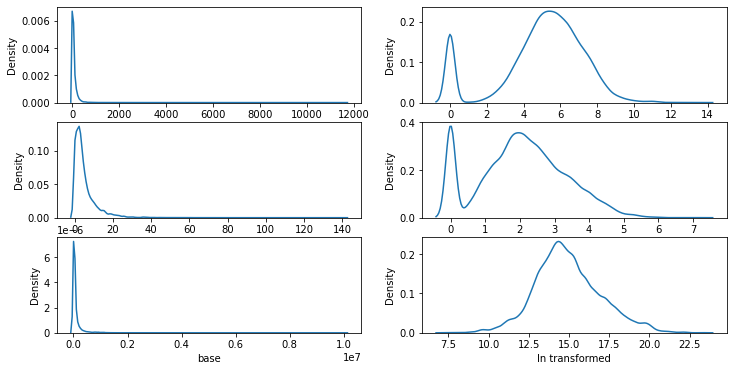

In [14]:
figure(figsize = (12, 6))

plt.subplot(3, 2, 1)
sns.kdeplot(np.array(df_2022["covid_cases_per_100k"]))

plt.subplot(3, 2, 2)
sns.kdeplot(np.array(df_2022["ln_covid_cases"]))


plt.subplot(3, 2, 3)
sns.kdeplot(np.array(df_2022["covid_hospital_admissions_per_100k"]))

plt.subplot(3, 2, 4)
sns.kdeplot(np.array(df_2022["ln_covid_hospital"]))


plt.subplot(3, 2, 5)
sns.kdeplot(np.array(df_2022["county_population"]))
plt.xlabel("base")

plt.subplot(3, 2, 6)
sns.kdeplot(np.array(df_2022["ln_population"]))
plt.xlabel("ln transformed")

In [15]:
df_2022 = df_2022[["ln_covid_cases",
                   "ln_covid_hospital",
                   "Series_Complete_Pop_Pct",
                   "Booster_Doses_Vax_Pct",
                   "ln_population",
                   "Trump",
                   "Biden"]]

df_2022

,ln_covid_cases,ln_covid_hospital,Series_Complete_Pop_Pct,Booster_Doses_Vax_Pct,ln_population,Trump,Biden
0,7.148121,4.452859,39.9,31.7,14.681238,0.864727,0.127142
47465,7.059182,3.498251,34.0,20.2,11.561765,0.893145,0.091734
8352,5.880196,4.842979,40.4,29.6,14.076064,0.000000,0.000142
8351,5.880196,4.842979,40.4,29.6,14.076064,0.158209,0.076475
8350,5.880196,4.842979,40.4,29.6,14.076064,0.469225,0.143284
...,...,...,...,...,...,...,...
51939,5.501439,1.536053,46.1,20.5,14.462374,0.176699,0.229135
12173,4.323370,1.887525,34.9,35.4,12.360298,0.067692,0.069011
36660,4.556429,1.201634,36.8,31.8,14.437947,0.030388,0.027715
19194,4.433627,0.000000,35.5,46.7,13.244364,0.802220,0.177566


Since there is a larger amount of 0s in my dataset, the data does not fit a normal distribution too well (see plots below). So, I decided to make another dataset that excluded 0s. While this narrows down the appplicability of the model, I decided that it was worth to see how much better the model would perform on the dataset without 0s.

In [16]:
df_2022_zero_filt = df_2022[(df_2022["ln_covid_cases"] > 0) &
                            (df_2022["ln_covid_hospital"] > 0) & 
                            (df_2022["Series_Complete_Pop_Pct"] > 0) &
                            (df_2022["Booster_Doses_Vax_Pct"] > 0) &
                            (df_2022["Trump"] > 0) &
                            (df_2022["Biden"] > 0) &
                            (df_2022["ln_population"] > 0)]

df_2022_zero_filt

,ln_covid_cases,ln_covid_hospital,Series_Complete_Pop_Pct,Booster_Doses_Vax_Pct,ln_population,Trump,Biden
0,7.148121,4.452859,39.9,31.7,14.681238,0.864727,0.127142
47465,7.059182,3.498251,34.0,20.2,11.561765,0.893145,0.091734
8351,5.880196,4.842979,40.4,29.6,14.076064,0.158209,0.076475
8350,5.880196,4.842979,40.4,29.6,14.076064,0.469225,0.143284
8349,5.880196,4.842979,40.4,29.6,14.076064,0.069083,0.072779
...,...,...,...,...,...,...,...
51941,5.501439,1.536053,46.1,20.5,14.462374,0.001616,0.001454
51940,5.501439,1.536053,46.1,20.5,14.462374,0.475156,0.099539
51939,5.501439,1.536053,46.1,20.5,14.462374,0.176699,0.229135
12173,4.323370,1.887525,34.9,35.4,12.360298,0.067692,0.069011


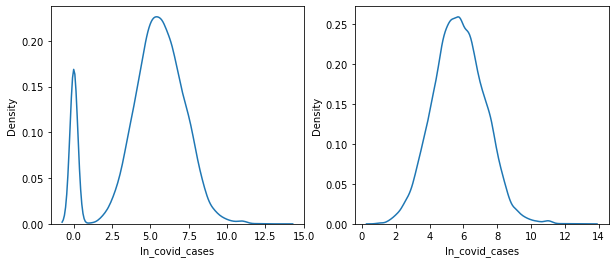

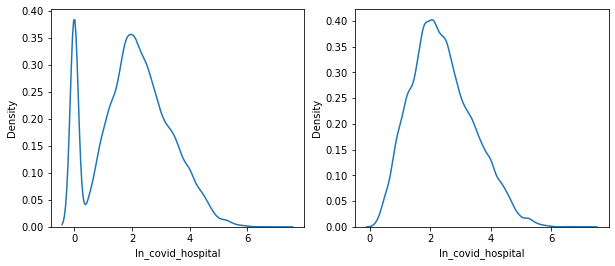

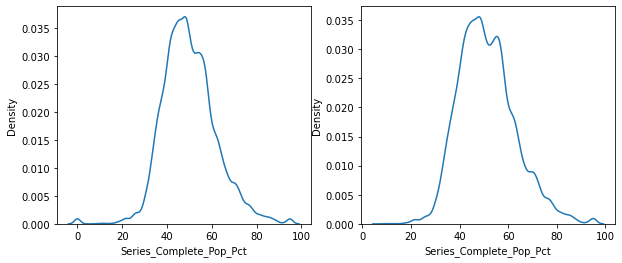

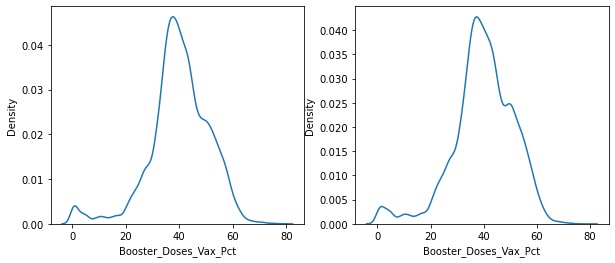

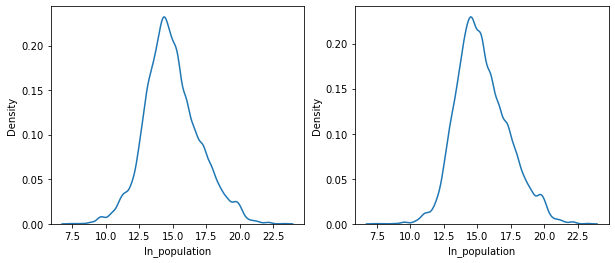

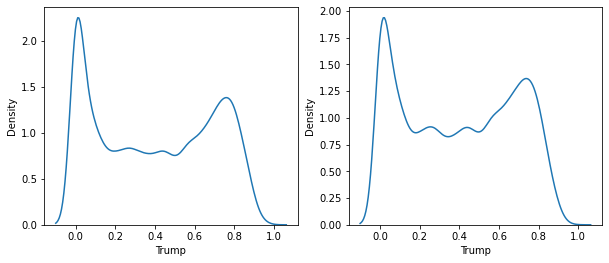

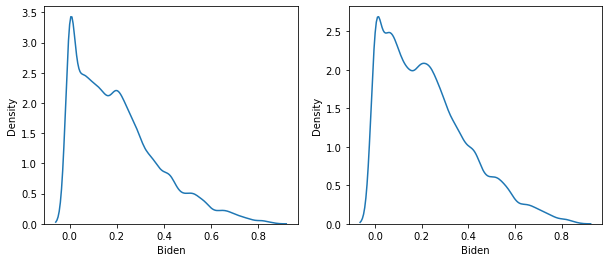

In [17]:
for index in range(df_2022.shape[1]):
    
    x = df_2022.iloc[:, index]
    x_filt = df_2022_zero_filt.iloc[:, index]

    figure(figsize = (10, 4))

    plt.subplot(1, 2, 1)
    sns.kdeplot(np.array(x))
    plt.xlabel(df_2022.columns[index])

    plt.subplot(1, 2, 2)
    sns.kdeplot(np.array(x_filt))
    plt.xlabel(df_2022_zero_filt.columns[index])

After I was done preparing my data, I made some basic scatterplots to examine the linear relationship between the covid rates and my features. On visual examination, only the relationship between covid cases and hospitalization rates seemed to be positively correlated. Perhaps surprisingly, vaccination rates and booster rates did not seem to be visibly correlated with covid rates. This wasn't great news for the expected performance of my model, but an interesting observation nonetheless.

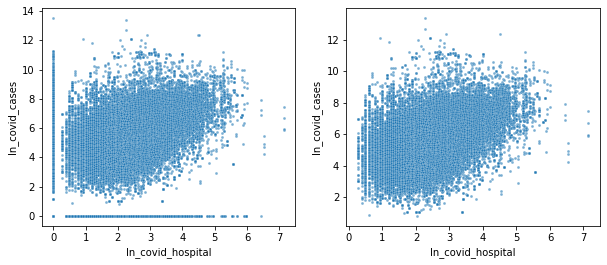

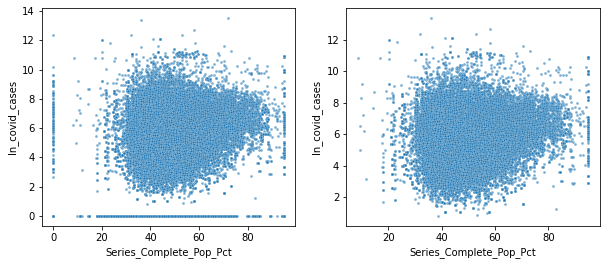

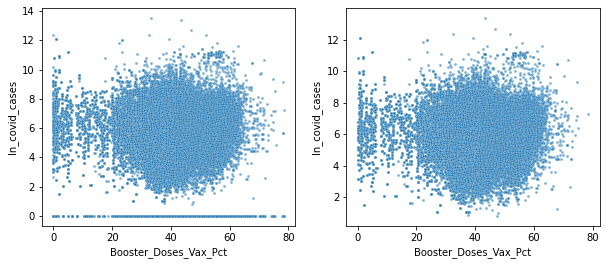

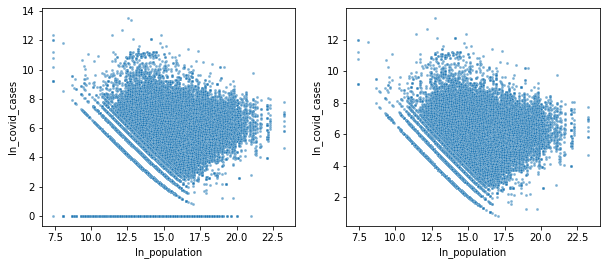

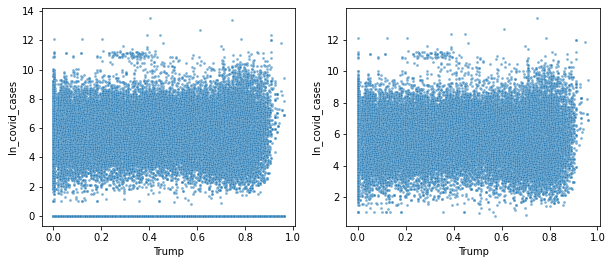

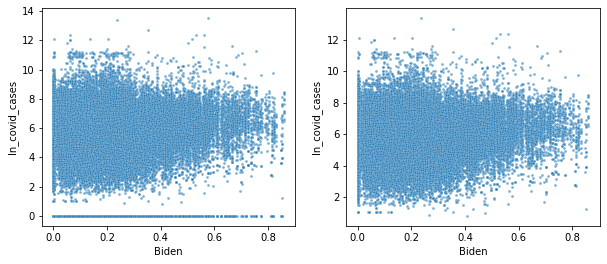

In [18]:
for index in range(1, df_2022.shape[1]):
    
    x = df_2022.iloc[:, index]
    y = df_2022.ln_covid_cases

    x_filt = df_2022_zero_filt.iloc[:, index]
    y_filt = df_2022_zero_filt.ln_covid_cases

    figure(figsize = (10, 4))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x = x, y = y, s = 8, alpha = 0.6)

    plt.subplot(1, 2, 2)
    sns.scatterplot(x = x_filt, y = y_filt, s = 8, alpha = 0.6)

I split up my two datasets into a training set and a test set using random sampling.

In [19]:
y_2022 = df_2022["ln_covid_cases"]
X_2022 = df_2022[["ln_covid_hospital", "Series_Complete_Pop_Pct", "Booster_Doses_Vax_Pct", "ln_population", "Trump", "Biden"]]

y_2022_train = y_2022.sample(frac = 0.8, random_state = 0)
y_2022_test = y_2022.drop(y_2022_train.index)

X_2022_train = X_2022.sample(frac = 0.8, random_state = 0)
X_2022_test = X_2022.drop(X_2022_train.index)


y_2022_filt = df_2022_zero_filt["ln_covid_cases"]
X_2022_filt = df_2022_zero_filt[["ln_covid_hospital", "Series_Complete_Pop_Pct", "Booster_Doses_Vax_Pct", "ln_population", "Trump", "Biden"]]

y_2022_filt_train = y_2022_filt.sample(frac = 0.8, random_state = 0)
y_2022_filt_test = y_2022_filt.drop(y_2022_filt_train.index)

X_2022_filt_train = X_2022_filt.sample(frac = 0.8, random_state = 0)
X_2022_filt_test = X_2022_filt.drop(X_2022_filt_train.index)

Finally, I was able to build and train my model. I used a normalizer to normalize my data and did some hyperparameter testing to find the optimal learning rate and momentum. I also used early stopping to prevent overfitting. I used the mean absolute error as my evaluation metric.

In [20]:
earlystopping = callbacks.EarlyStopping(monitor = "val_loss",
                                        mode = "min",
                                        patience = 5,
                                        restore_best_weights = True)

normalizer =  tf.keras.layers.Normalization(axis = -1)
normalizer.adapt(np.array(X_2022_train))

def model_builder(hp):
    linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units = 1)])

    hp_learning_rate = hp.Choice("learning_rate", values = [0.1, 0.01, 0.001, 0.0001])
    
    hp_momentum = hp.Choice("momentum", values = [0.6, 0.7, 0.8, 0.9])

    linear_model.compile(
        optimizer = tf.optimizers.SGD(learning_rate = hp_learning_rate, momentum = hp_momentum),
        loss = "mean_absolute_error")

    return linear_model

In [21]:
tuner = kt.BayesianOptimization(model_builder,
                     objective = "val_loss",
                     max_trials = 10)

tuner.search(X_2022_train, y_2022_train, epochs = 50, validation_split = 0.2, callbacks = [earlystopping])

Trial 10 Complete [00h 00m 16s]
val_loss: 1.4871535301208496

Best val_loss So Far: 1.4869660139083862
Total elapsed time: 00h 05m 04s
INFO:tensorflow:Oracle triggered exit


In [22]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [23]:
linear_model = tuner.hypermodel.build(best_hps)

history_2022 = linear_model.fit(
    X_2022_train,
    y_2022_train,
    epochs = 50,
    verbose = 1,
    validation_split = 0.2,
    batch_size = 16,
    callbacks = [earlystopping])

val_loss_per_epoch = history_2022.history["val_loss"]
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

Epoch 1/50
2233/2233 [==============================] - 2s 986us/step - loss: 2.3531 - val_loss: 1.4966
Epoch 2/50
2233/2233 [==============================] - 2s 878us/step - loss: 1.4733 - val_loss: 1.4872
Epoch 3/50
2233/2233 [==============================] - 2s 970us/step - loss: 1.4724 - val_loss: 1.4876
Epoch 4/50
2233/2233 [==============================] - 2s 877us/step - loss: 1.4721 - val_loss: 1.4876
Epoch 5/50
2233/2233 [==============================] - 2s 978us/step - loss: 1.4722 - val_loss: 1.4873
Epoch 6/50
2233/2233 [==============================] - 2s 930us/step - loss: 1.4721 - val_loss: 1.4878
Epoch 7/50
2233/2233 [==============================] - 3s 1ms/step - loss: 1.4722 - val_loss: 1.4874
Best epoch: 2


In [24]:
hypermodel = tuner.hypermodel.build(best_hps)

history_hypermodel = hypermodel.fit(X_2022_train,
    y_2022_train,
    epochs = best_epoch,
    verbose = 1,
    validation_split = 0.2,
    batch_size = 16,
    callbacks = [earlystopping])

Epoch 1/2
2233/2233 [==============================] - 3s 1ms/step - loss: 2.5553 - val_loss: 1.4958
Epoch 2/2
2233/2233 [==============================] - 2s 969us/step - loss: 1.4734 - val_loss: 1.4871


In [25]:
hypermodel.evaluate(X_2022_test, y_2022_test, verbose = 1)

349/349 [==============================] - 0s 745us/step - loss: 1.4802


1.4801996946334839

In [26]:
hypermodel.layers[1].kernel

<tf.Variable 'dense_2/kernel:0' shape=(6, 1) dtype=float32, numpy=
array([[ 0.8315651 ],
       [ 0.20216773],
       [-0.15930402],
       [ 0.10474581],
       [-0.03891541],
       [ 0.14677209]], dtype=float32)>

In [27]:
normalizer.adapt(np.array(X_2022_filt_train))

history_2022_filt = hypermodel.fit(
    X_2022_filt_train,
    y_2022_filt_train,
    epochs = best_epoch,
    verbose = 1,
    validation_split = 0.2,
    batch_size = 16,
    callbacks = [earlystopping])

Epoch 1/2
1687/1687 [==============================] - 2s 1ms/step - loss: 1.0151 - val_loss: 1.0379
Epoch 2/2
1687/1687 [==============================] - 2s 1ms/step - loss: 1.0097 - val_loss: 1.0349


In [28]:
hypermodel.evaluate(X_2022_filt_test, y_2022_filt_test, verbose = 1)

264/264 [==============================] - 0s 840us/step - loss: 1.0462


1.0461580753326416

In [29]:
hypermodel.layers[1].kernel

<tf.Variable 'dense_2/kernel:0' shape=(6, 1) dtype=float32, numpy=
array([[ 0.75179935],
       [ 0.19062339],
       [-0.1597054 ],
       [-0.03694226],
       [-0.06662872],
       [ 0.17011087]], dtype=float32)>

Results:

My model was able to predict covid rates with a mean absolute error of around 1.45.
When using the dataset without 0s, the error of the model decreased by about 0.4. This was to be expected as the dataset without 0s more closely resembled data drawn from a normal distribution.